In [1]:
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
import sys
from pathlib import Path
from string import ascii_lowercase, ascii_uppercase

import cartopy.crs as ccrs

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from cmap import Colormap


import numpy as np
import pandas as pd
import xarray as xr
from IPython.display import HTML, Image, display
from scipy import stats

In [2]:
xr.set_options(keep_attrs=True)
infile_path = Path("/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/")
plt.rcParams.update({"font.size": 25})

In [3]:
from dask.distributed import LocalCluster

# https://forum.access-hive.org.au/t/netcdf-not-a-valid-id-errors/389/12
cluster = LocalCluster(threads_per_worker=1)          # Fully-featured local Dask cluster
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 56
Total threads: 56,Total memory: 755.78 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41941,Workers: 56
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 755.78 GiB
Comm: tcp://127.0.0.1:41403,Total threads: 1
Dashboard: http://127.0.0.1:42395/status,Memory: 13.50 GiB
Nanny: tcp://127.0.0.1:35867,


In [53]:
def process(ds, deseasonalize=True, upper_limit=0.1, lower_limit=300):
    #ds = ds.drop_vars(["var152", "time_bnds", "lat_bnds"], errors="ignore")
    ds["time"] = pd.date_range("2022-01", freq="D", periods=ds.time.shape[0])
    ds["plev"] = ds.plev.values / 100.0
    ds["plev"].attrs["units"] = "hPa"
    ds["plev"].attrs["long_name"] = "pressure"
    ds["plev"].attrs["standard_name"] = "pressure"

    if deseasonalize:
        ds = anomalize_func(ds)  # deseasonalize_func(ds)

    return ds#.sel(plev=slice(upper_limit, lower_limit))

def process_vertically(ds, deseasonalize=True, upper_limit=0.01, lower_limit=150):
    #ds = ds.drop_vars(["var152", "time_bnds", "lat_bnds"], errors="ignore")
    ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])
    ds["plev"] = ds.plev.values / 100.0
    ds["plev"].attrs["units"] = "hPa"
    ds["plev"].attrs["long_name"] = "pressure"
    ds["plev"].attrs["standard_name"] = "pressure"

    if deseasonalize:
        ds = anomalize_func(ds)  # deseasonalize_func(ds)

    return ds.sel(plev=slice(upper_limit, lower_limit))


def anomalize_func(ds):
    time_var = "time"
    climatology = (
        ds.sel(time=slice("2022-01", "2022-12"))
        .groupby(time_var + ".month")
        .mean(time_var)
    )
    anomalies = ds.copy()
    for sel_var in list(ds.data_vars)[:]:
        if sel_var in ["O3_m", "H2O_m"]:
            anomalies[sel_var] = (
                (ds[sel_var] - climatology[sel_var]) / climatology[sel_var] * 100
            )
            anomalies[sel_var].attrs["units"] = "%"
        else:
            anomalies[sel_var] = ds[sel_var] - climatology[sel_var]
            anomalies[sel_var].attrs["units"] = ds[sel_var].attrs["units"]
    return anomalies

# https://wiki.mpimet.mpg.de/doku.php?id=analysis:pot_pourri:statistics:controlling_fdr
def xr_multipletest(p, alpha=0.05, method="fdr_bh", **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests

    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs
    )[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs
    )[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected

# Geopotential height

In [10]:
what = "dyn"
infiles_w = list(infile_path.glob(f"HT_socol4_htt1*{what}*"))
infiles_wo = list(infile_path.glob(f"HT_socol4_htt2*{what}*"))

In [7]:
ds = xr.open_dataset(infiles_w[0]).pipe(process)
ds

<xarray.Dataset> Size: 6GB
Dimensions:  (time: 1461, lon: 192, lat: 96, plev: 5, month: 12)
Coordinates:
  * time     (time) datetime64[ns] 12kB 2022-01-01 2022-01-02 ... 2025-12-31
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 40B 10.0 50.0 100.0 200.0 500.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    zg       (time, plev, lat, lon, month) float32 6GB -457.8 -584.4 ... 23.61
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Mon Sep 16 18:27:04 2024: cdo cat /home/sutimofe/Tmp/HT_pap...
    institution:  MPIMET
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

In [12]:
opts = dict(
    paths=infiles_wo,
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim="ens",
    # data_vars="minimal",
)
ds_wo = xr.open_mfdataset(**opts).pipe(process, deseasonalize=False)
ds_wo

<xarray.Dataset> Size: 5GB
Dimensions:  (time: 1461, lon: 192, lat: 96, plev: 5, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 12kB 2022-01-01 2022-01-02 ... 2025-12-31
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 40B 10.0 50.0 100.0 200.0 500.0
Dimensions without coordinates: ens
Data variables:
    zg       (ens, time, plev, lat, lon) float32 5GB dask.array<chunksize=(1, 1461, 5, 96, 192), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Tue Sep 17 14:23:56 2024: cdo cat /home/sutimofe/Tmp/HT_pap...
    institution:  MPIMET
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

In [13]:
opts = dict(
    paths=infiles_w,
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim="ens",
    # data_vars="minimal",
)
ds_w = xr.open_mfdataset(**opts).pipe(process, deseasonalize=False)
ds_w

<xarray.Dataset> Size: 5GB
Dimensions:  (time: 1461, lon: 192, lat: 96, plev: 5, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 12kB 2022-01-01 2022-01-02 ... 2025-12-31
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 40B 10.0 50.0 100.0 200.0 500.0
Dimensions without coordinates: ens
Data variables:
    zg       (ens, time, plev, lat, lon) float32 5GB dask.array<chunksize=(1, 1461, 5, 96, 192), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Mon Sep 16 18:27:04 2024: cdo cat /home/sutimofe/Tmp/HT_pap...
    institution:  MPIMET
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

In [20]:
arr2

<xarray.DataArray 'zg' (ens: 10, time: 30, plev: 5, lat: 96, lon: 192)> Size: 111MB
dask.array<getitem, shape=(10, 30, 5, 96, 192), dtype=float32, chunksize=(1, 30, 5, 96, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 240B 2023-04-01 2023-04-02 ... 2023-04-30
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 40B 10.0 50.0 100.0 200.0 500.0
Dimensions without coordinates: ens
Attributes:
    standard_name:  geopotential_height
    units:          m
    code:           156

In [28]:
time_slice = "2023-04"#slice("2022-11-01", "2023-04-30")
sel_dict = dict(time=time_slice, lat=slice(None, None))
sel_var = "zg"


arr1 = ds_w[sel_var].sel(**sel_dict).squeeze().mean('time')
arr2 = ds_wo[sel_var].sel(**sel_dict).squeeze().mean('time')
dims_to_ave = ('ens')
diff = arr1.mean(dims_to_ave) - arr2.mean(dims_to_ave)
#diff["time"] = map_time_str(diff.time)
#diff.attrs["units"] = "%"
#diff.attrs['standard_name'] = 'SLP'

t_stat, p_values = stats.ttest_ind(
    arr1, arr2, equal_var=False
)  # , nan_policy = nan_policy)
diff_pv = xr.DataArray(p_values, coords=diff.coords)
diff_pv_fdr = xr_multipletest(diff_pv)[1]

In [27]:
arr1

<xarray.DataArray 'zg' (ens: 10, time: 30, plev: 5, lat: 96, lon: 192)> Size: 111MB
dask.array<getitem, shape=(10, 30, 5, 96, 192), dtype=float32, chunksize=(1, 30, 5, 96, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 240B 2023-04-01 2023-04-02 ... 2023-04-30
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 40B 10.0 50.0 100.0 200.0 500.0
Dimensions without coordinates: ens
Attributes:
    standard_name:  geopotential_height
    units:          m
    code:           156

In [ ]:
p.map_dataarray

/tmp/ipykernel_25663/370313336.py:46: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  zip(p.axes.flat, p.name_dicts.flat, ascii_uppercase)


zg_map_2023-04_alaSLP_multi-plevs.pdf


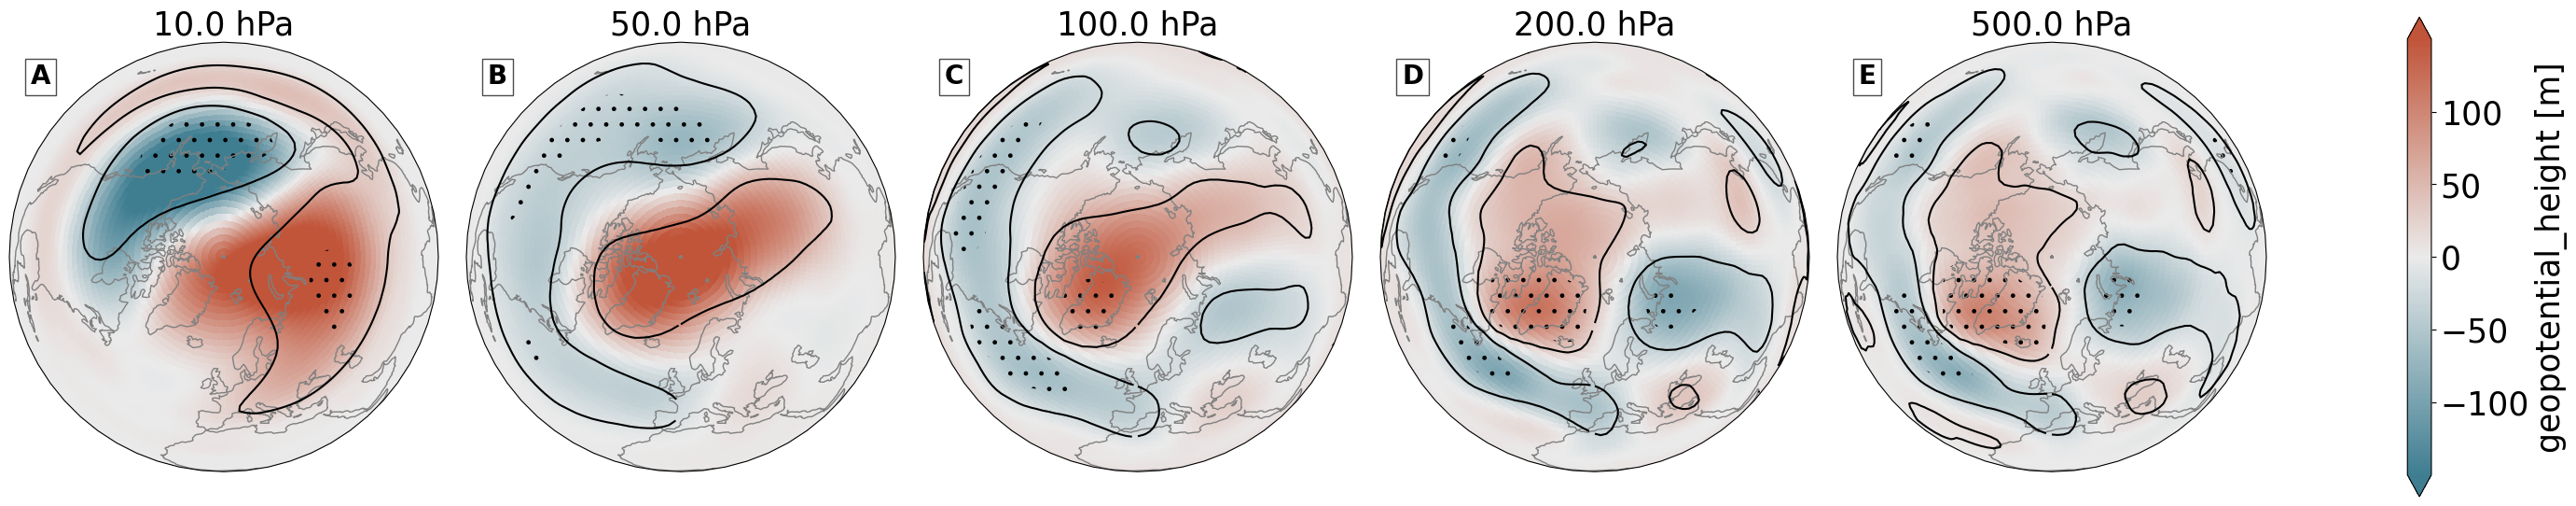

In [45]:
cm = Colormap('vispy:RdBu_r')#'crameri:vik')

p = diff.plot(
    col = 'plev',
    subplot_kws=dict(projection=ccrs.Orthographic(0, 90), facecolor="gray"),
    size = 6,
    transform=ccrs.PlateCarree(),
    robust = True,
    cmap=cm.to_matplotlib(),#"PuOr_r",
    #levels = 21,
    extend = 'both',
    #cbar_kwargs = dict(ticks=[-6,-3, 0, 3,6])
    
)

kwargs = dict(
    # colors=("k"),
    #col = 'plev',
    add_colorbar=False,
    levels=[0, 0.05],
    colors="none",
    hatches=[
        ".",#"//",
        None,
    ],
    transform=ccrs.PlateCarree()
    # linewidths=np.linspace(1, 4, 4),
)

p.data = diff_pv
#diff_pv.plot.contourf(**kwargs)
p.map_dataarray(xr.plot.contourf, "lon", "lat", **kwargs)

kwargs = dict(
    colors=("k"),
    add_colorbar=False,
    levels=[0, 0.32],
    transform=ccrs.PlateCarree()
)
#diff_pv_fdr.plot.contour(**kwargs)
p.map_dataarray(xr.plot.contour, "lon", "lat", **kwargs)
p.set_titles("{value} hPa")

j = 0
for i, (ax, sel_dict, label) in enumerate(
    zip(p.axes.flat, p.name_dicts.flat, ascii_uppercase)
):
    fmt = mpl.ticker.FormatStrFormatter("%g")
    ax.yaxis.set_major_formatter(fmt)
    ax.text(
        0.05,
        0.95,
        ascii_uppercase[j],#f'{sel_var[:-2]} ({label})',
        transform=ax.transAxes,
        fontsize=20,
        fontweight="bold",
        va="top",
        bbox={"alpha": 0.7, "facecolor": "white"},
    )
    ax.set_global()
    ax.coastlines(color = 'gray')

    j+=1

outfile = f"{sel_var}_map_{time_slice}_alaSLP_multi-plevs.pdf"
print(outfile)
plt.savefig(outfile, bbox_inches="tight")

# Plume evolution

## H2O

In [5]:
what = "chem_m"
infiles_w = list(infile_path.glob(f"socol4_htt1*{what}*"))
infiles_wo = list(infile_path.glob(f"socol4_htt2*{what}*"))

In [6]:
infiles_wo

[PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt28_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt29_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt24_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt25_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt27_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt26_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt23_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt22_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt20_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt21_chem_mm_zon_2021-2025.nc')]

In [7]:
infiles_w

[PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt18_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt19_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt17_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt16_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt14_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt15_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt10_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt11_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt13_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt12_chem_mm_zon_2021-2025.nc')]

In [54]:
opts = dict(
    paths=infiles_w,
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim="ens",
    #data_vars="minimal",
)
ds_w = xr.open_mfdataset(**opts).pipe(process_vertically, deseasonalize=False)
ds_w

/tmp/ipykernel_3670/299625489.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset> Size: 20MB
Dimensions:    (time: 60, ens: 10, bnds: 2, lon: 1, lat: 96, plev: 22)
Coordinates:
  * time       (time) datetime64[ns] 480B 2021-01-31 2021-02-28 ... 2025-12-31
  * lon        (lon) float64 8B 0.0
  * lat        (lat) float64 768B 88.57 86.72 84.86 ... -84.86 -86.72 -88.57
  * plev       (plev) float64 176B 0.04281 0.1112 0.2315 ... 91.02 110.7 132.4
Dimensions without coordinates: ens, bnds
Data variables:
    time_bnds  (ens, time, bnds) float64 10kB dask.array<chunksize=(1, 60, 2), meta=np.ndarray>
    var152     (ens, lat, lon) float32 4kB dask.array<chunksize=(1, 96, 1), meta=np.ndarray>
    te_m       (ens, time, plev, lat, lon) float32 5MB dask.array<chunksize=(1, 60, 22, 96, 1), meta=np.ndarray>
    u_m        (ens, time, plev, lat, lon) float32 5MB dask.array<chunksize=(1, 60, 22, 96, 1), meta=np.ndarray>
    O3_m       (ens, time, plev, lat, lon) float32 5MB dask.array<chunksize=(1, 60, 22, 96, 1), meta=np.ndarray>
    H2O_m      (ens, time, plev, lat, lon) float32 5MB dask.array<chunksize=(1, 60, 22, 96, 1), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Tue Mar 12 10:25:13 2024: cdo cat ss4.nc /scratch/snx3000/a...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [55]:
opts = dict(
    paths=infiles_wo,
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim="ens",
    #data_vars="minimal",
)
ds_wo = xr.open_mfdataset(**opts).pipe(process_vertically, deseasonalize=False)
ds_wo

/tmp/ipykernel_3670/299625489.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset> Size: 20MB
Dimensions:    (time: 60, lon: 1, lat: 96, plev: 22, ens: 10, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 480B 2021-01-31 2021-02-28 ... 2025-12-31
  * lon        (lon) float64 8B 0.0
  * lat        (lat) float64 768B 88.57 86.72 84.86 ... -84.86 -86.72 -88.57
  * plev       (plev) float64 176B 0.04281 0.1112 0.2315 ... 91.02 110.7 132.4
Dimensions without coordinates: ens, bnds
Data variables:
    time_bnds  (ens, time, bnds) float64 10kB dask.array<chunksize=(1, 60, 2), meta=np.ndarray>
    var152     (ens, lat, lon) float32 4kB dask.array<chunksize=(1, 96, 1), meta=np.ndarray>
    te_m       (ens, time, plev, lat, lon) float32 5MB dask.array<chunksize=(1, 60, 22, 96, 1), meta=np.ndarray>
    u_m        (ens, time, plev, lat, lon) float32 5MB dask.array<chunksize=(1, 60, 22, 96, 1), meta=np.ndarray>
    O3_m       (ens, time, plev, lat, lon) float32 5MB dask.array<chunksize=(1, 60, 22, 96, 1), meta=np.ndarray>
    H2O_m      (ens, time, plev, lat, lon) float32 5MB dask.array<chunksize=(1, 60, 22, 96, 1), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Thu Feb 29 16:07:22 2024: cdo cat ss4.nc /scratch/snx3000/a...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [11]:
weights = np.cos(np.deg2rad(ds_w.lat))
weights.name = "weights"
weights

<xarray.DataArray 'weights' (lat: 96)> Size: 768B
array([0.02491778, 0.05717144, 0.08955539, 0.12188768, 0.15410725,
       0.1861715 , 0.21804295, 0.24968611, 0.28106651, 0.31215034,
       0.34290431, 0.37329559, 0.40329182, 0.43286109, 0.46197199,
       0.49059359, 0.51869553, 0.54624798, 0.57322171, 0.59958812,
       0.62531924, 0.65038779, 0.6747672 , 0.6984316 , 0.72135592,
       0.74351585, 0.76488791, 0.78544943, 0.80517862, 0.82405458,
       0.84205728, 0.85916766, 0.87536757, 0.89063985, 0.9049683 ,
       0.91833775, 0.93073401, 0.94214396, 0.9525555 , 0.96195759,
       0.97034027, 0.97769466, 0.98401296, 0.98928847, 0.9935156 ,
       0.99668988, 0.99880794, 0.99986753, 0.99986753, 0.99880794,
       0.99668988, 0.9935156 , 0.98928847, 0.98401296, 0.97769466,
       0.97034027, 0.96195759, 0.9525555 , 0.94214396, 0.93073401,
       0.91833775, 0.9049683 , 0.89063985, 0.87536757, 0.85916766,
       0.84205728, 0.82405458, 0.80517862, 0.78544943, 0.76488791,
       0.74351585, 0.72135592, 0.6984316 , 0.6747672 , 0.65038779,
       0.62531924, 0.59958812, 0.57322171, 0.54624798, 0.51869553,
       0.49059359, 0.46197199, 0.43286109, 0.40329182, 0.37329559,
       0.34290431, 0.31215034, 0.28106651, 0.24968611, 0.21804295,
       0.1861715 , 0.15410725, 0.12188768, 0.08955539, 0.05717144,
       0.02491778])
Coordinates:
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

In [41]:
def difference_calc(ds_w, ds_wo, sel_var, sel_dict, conv = 1):
    arr1 = ds_w[sel_var].sel(**sel_dict).squeeze().weighted(weights).mean(['lat']).load()*conv
    arr2 = ds_wo[sel_var].sel(**sel_dict).squeeze().weighted(weights).mean(['lat']).load()*conv


    dims_to_ave = ('ens')
    diff = (arr1.mean(dims_to_ave) - arr2.mean(dims_to_ave))

    return arr1, arr2, diff
    

In [61]:
time_slice = slice("2022-01", "2025-01")
sel_dict = dict(time=time_slice, lat=slice(None, None))
sel_var = 'H2O_m'
conv = 1e6  # to ppmv

arr1 = ds_w[sel_var].sel(**sel_dict).squeeze().weighted(weights).mean(['lat']).load()*conv
arr2 = ds_wo[sel_var].sel(**sel_dict).squeeze().weighted(weights).mean(['lat']).load()*conv


dims_to_ave = ('ens')
diff = (arr1.mean(dims_to_ave) - arr2.mean(dims_to_ave))
#diff["time"] = map_time_str(diff.time)
#diff.attrs["units"] = "%"
#diff.attrs['standard_name'] = 'SLP'



In [ ]:
t_stat, p_values = stats.ttest_ind(
    arr1, arr2, equal_var=False
)  # , nan_policy = nan_policy)
diff_pv = xr.DataArray(p_values, coords=diff.coords)
diff_pv_fdr = xr_multipletest(diff_pv)[1]

In [52]:
diff

<xarray.DataArray 'H2O_m' (time: 48, plev: 20)> Size: 8kB
array([[ 3.66819279e-03,  2.31625090e-03,  8.15028007e-04,
         3.83758281e-04, -2.74410528e-03, -6.11742582e-03,
        -6.78266586e-03, -6.05407617e-03, -3.72173763e-03,
        -3.04394181e-03,  4.86102474e-04,  3.69787102e-03,
         6.16417409e-03,  6.87113539e-03,  7.28722351e-03,
         6.40980888e-03,  7.93391224e-04, -6.00006589e-03,
        -1.24399426e-02, -2.23087366e-02],
       [ 2.31456570e-02, -3.12841270e-03, -1.39158609e-02,
        -1.78183170e-02, -1.91998420e-02, -4.22938114e-03,
         3.60874820e-02,  1.17014813e-01,  3.17312258e-01,
         8.08577660e-01,  1.84392739e+00,  2.90972320e+00,
         2.70042586e+00,  1.40608893e+00,  5.22857297e-01,
         1.68778999e-01,  3.94266698e-02, -2.12645912e-02,
        -5.78517445e-02, -6.22714807e-02],
       [ 7.57764409e-02,  2.81828613e-02, -3.02690090e-02,
        -3.30268473e-02,  2.94806419e-02,  1.67123070e-01,
         3.60812938e-01,  6.80532790e-01,  1.21715658e+00,
         1.94618304e+00,  2.52461223e+00,  2.49573428e+00,
         1.80823227e+00,  1.05126092e+00,  5.32609135e-01,
         2.25232956e-01,  3.83255417e-02, -3.57066983e-02,
...
         1.12320710e-01,  1.15338662e-01,  1.15806530e-01,
         1.16081707e-01,  1.21635956e-01,  1.25750848e-01,
         1.27529034e-01,  1.22443816e-01,  1.22254924e-01,
         1.25038224e-01,  1.17519870e-01,  1.08097776e-01,
         1.04051642e-01,  7.95559313e-02,  4.72207606e-02,
         2.25969604e-02,  1.06283176e-02],
       [ 3.57326353e-02,  7.67554254e-02,  1.00528590e-01,
         1.03476664e-01,  1.04807255e-01,  1.11660067e-01,
         1.16317332e-01,  1.24349414e-01,  1.21260923e-01,
         1.20568812e-01,  1.16202532e-01,  1.16514517e-01,
         1.19437392e-01,  1.23119289e-01,  1.13236739e-01,
         9.07640469e-02,  7.28277860e-02,  5.34453640e-02,
         3.71612078e-02,  2.23444442e-02],
       [ 5.84596344e-02,  1.12035837e-01,  1.38033009e-01,
         1.29385675e-01,  1.16078711e-01,  1.05965966e-01,
         1.03913911e-01,  1.12887126e-01,  1.22537929e-01,
         1.20069418e-01,  1.13604616e-01,  1.11348370e-01,
         1.14368367e-01,  1.12332223e-01,  1.10239310e-01,
         9.87437948e-02,  7.37905148e-02,  4.44345488e-02,
        -1.99691610e-02, -4.54011047e-02]])
Coordinates:
  * time     (time) datetime64[ns] 384B 2022-01-31 2022-02-28 ... 2025-12-31
    lon      float64 8B 0.0
  * plev     (plev) float64 160B 0.04281 0.1112 0.2315 ... 59.64 74.06 91.02
Attributes:
    long_name:         H2O volume mixing ratio
    units:             mol/mol
    code:              35
    table:             199
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  48
    institution:       MPIMET

TE+H2O+O3_time-evolution_globally.pdf


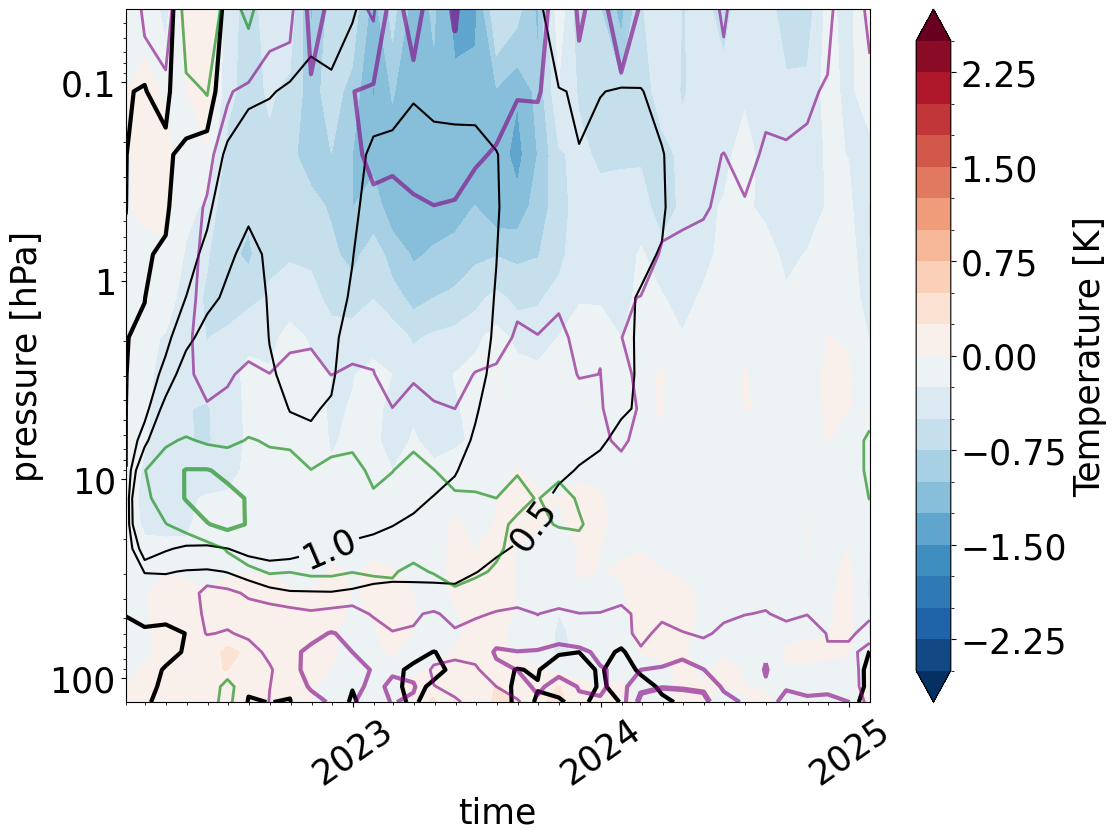

In [83]:
time_slice = slice("2022-01", "2025-01")
sel_dict = dict(time=time_slice, lat=slice(None, None))

_,_, diff = difference_calc(ds_w, ds_wo, 'te_m', sel_dict)
p = diff.plot.contourf(x = 'time', yincrease = False, levels=np.linspace(-2.5,2.5,21), extend = 'both', size=9)
ax = p.axes



_,_, diff = difference_calc(ds_w, ds_wo, 'H2O_m', sel_dict, conv=1e6)
diff.plot.contour(x = 'time', yincrease = False, levels=[0], extend = 'both', colors = ('k'), linewidths=3, ax = ax)
CS = diff.plot.contour(x = 'time', yincrease = False, levels=[0.5, 1, 3], extend = 'both', colors = ('k'), ax = ax)
ax.clabel(CS)

arr1,arr2, _ = difference_calc(ds_w, ds_wo, 'O3_m', sel_dict, conv=1)
diff = ((arr1 - arr2) / arr1 * 100).mean("ens")  # *conv
diff.attrs["units"] = "%"
#diff.plot.contour(x = 'time', yincrease = False, levels=[0], extend = 'both', colors = ('k'), linewidths=3, ax = ax)
CS = diff.plot.contour(x = 'time', yincrease = False, levels=[1, 3, 5], extend = 'both', colors = ('green','green','green'), ax = ax, linewidths=np.linspace(2, 4, 3), alpha = 0.6)
#ax.clabel(CS)

CS = diff.plot.contour(x = 'time', yincrease = False, levels=[-5, -3, -1], extend = 'both', colors = ('purple','purple','purple'), ax = ax, linewidths=np.linspace(4, 2, 3), alpha = 0.6)
#ax.clabel(CS)


ax.set_title('')
ax.set_yscale('log')

fmt = mpl.ticker.FormatStrFormatter("%g")
ax.yaxis.set_major_formatter(fmt)

X = ax.xaxis
X.set_major_locator(mdates.YearLocator())
X.set_minor_locator(mdates.MonthLocator())
#X.set_major_formatter(fmt)
X.set_tick_params(rotation=35)

outfile = f"TE+H2O+O3_time-evolution_globally.pdf"
print(outfile)
plt.savefig(outfile, bbox_inches="tight")

In [84]:
!pwd

/home/kales
